<a href="https://colab.research.google.com/github/jungfrau70/encore-4team/blob/main/3_masks_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Masks Detection Web Service

참조

https://masks-detection-13237.web.app

https://github.com/ohyicong/masksdetection.git

# Download Code from GITHUB

https://github.com/jungfrau70/project1-masksdetection.git

In [1]:
!git clone https://github.com/jungfrau70/project1-masksdetection.git

Cloning into 'project1-masksdetection'...
remote: Enumerating objects: 3247, done.
remote: Counting objects: 100% (3247/3247), done.
remote: Compressing objects: 100% (2920/2920), done.
remote: Total 3247 (delta 314), reused 3243 (delta 313), pack-reused 0
Receiving objects: 100% (3247/3247), 103.32 MiB | 32.63 MiB/s, done.
Resolving deltas: 100% (314/314), done.


## STEP 1. import

In [2]:
# import the necessary packages
import argparse
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

## STEP 2. 전처리 (pre-processing)

In [3]:
print(os.getcwd())
!ls -al project1-masksdetection

/content
total 120
drwxr-xr-x 13 root root  4096 May 29 23:25 .
drwxr-xr-x  1 root root  4096 May 29 23:25 ..
-rw-r--r--  1 root root  5788 May 29 23:25 create_augmented_dataset.py
drwxr-xr-x  4 root root  4096 May 29 23:25 dataset
-rw-r--r--  1 root root  4848 May 29 23:25 detect_mask_video.py
-rw-r--r--  1 root root  1059 May 29 23:25 detect_mask_video.spec
-rw-r--r--  1 root root   153 May 29 23:25 docker-compose.yml
-rw-r--r--  1 root root   108 May 29 23:25 Dockerfile
drwxr-xr-x  2 root root  4096 May 29 23:25 face_detector
drwxr-xr-x  8 root root  4096 May 29 23:25 .git
-rw-r--r--  1 root root    32 May 29 23:25 .gitignore
drwxr-xr-x  3 root root  4096 May 29 23:25 .idea
drwxr-xr-x  2 root root  4096 May 29 23:25 images
drwxr-xr-x  2 root root  4096 May 29 23:25 .ipynb_checkpoints
-rw-r--r--  1 root root 22048 May 29 23:25 masks_detection.ipynb
drwxr-xr-x  2 root root  4096 May 29 23:25 model
drwxr-xr-x  2 root root  4096 May 29 23:25 plot
drwxr-xr-x  2 root root  4096 May 29 23:

In [4]:
import os
os.chdir('project1-masksdetection')
!ls -al .

total 120
drwxr-xr-x 13 root root  4096 May 29 23:25 .
drwxr-xr-x  1 root root  4096 May 29 23:25 ..
-rw-r--r--  1 root root  5788 May 29 23:25 create_augmented_dataset.py
drwxr-xr-x  4 root root  4096 May 29 23:25 dataset
-rw-r--r--  1 root root  4848 May 29 23:25 detect_mask_video.py
-rw-r--r--  1 root root  1059 May 29 23:25 detect_mask_video.spec
-rw-r--r--  1 root root   153 May 29 23:25 docker-compose.yml
-rw-r--r--  1 root root   108 May 29 23:25 Dockerfile
drwxr-xr-x  2 root root  4096 May 29 23:25 face_detector
drwxr-xr-x  8 root root  4096 May 29 23:25 .git
-rw-r--r--  1 root root    32 May 29 23:25 .gitignore
drwxr-xr-x  3 root root  4096 May 29 23:25 .idea
drwxr-xr-x  2 root root  4096 May 29 23:25 images
drwxr-xr-x  2 root root  4096 May 29 23:25 .ipynb_checkpoints
-rw-r--r--  1 root root 22048 May 29 23:25 masks_detection.ipynb
drwxr-xr-x  2 root root  4096 May 29 23:25 model
drwxr-xr-x  2 root root  4096 May 29 23:25 plot
drwxr-xr-x  2 root root  4096 May 29 23:25 __pyca

In [ ]:
!rm -rf model; mkdir model; ls -al model

In [6]:
# construct the argument parser and parse the arguments
dataset_path=os.getcwd()+"//dataset"
model_path=os.getcwd()+"//model//mask_model"
plot_path=os.getcwd()+"//plot"

In [7]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    # 위의 옵션 값들을 보고 적절히 대입하여 줍니다.
    rotation_range=20,
    zoom_range=0.15,  
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15, 
    horizontal_flip=True, 
    fill_mode='nearest', 
    validation_split=0.2
    )

In [8]:
TRAINING_DIR = "dataset/"

In [9]:
training_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                            target_size=(224, 224),
                                                            color_mode='rgb', classes=None,
                                                            class_mode='categorical',
                                                            batch_size=128,                                                            
                                                            subset='training', 
)

Found 1131 images belonging to 2 classes.


In [10]:
validation_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                            target_size=(224, 224),
                                                            color_mode='rgb', classes=None,
                                                            class_mode='categorical',
                                                            batch_size=128,                                                            
                                                            subset='validation', 
                                                            )

Found 282 images belonging to 2 classes.


## STEP 3. 모델 정의 (Sequential)


In [11]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


## STEP 4. optimizer, loss

In [12]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [13]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

[INFO] compiling model...


## STEP 5. ModelCheckpoint

In [14]:
checkpoint_path = "my_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

## STEP 6. 학습 (fit)

In [16]:
history = model.fit(training_generator,
          epochs=BS, 
          verbose=1, 
          callbacks=[checkpoint],
          validation_data=(validation_generator)
          )

Epoch 1/32
9/9 [==============================] - 16s 2s/step - loss: 0.1335 - acc: 0.9726 - val_loss: 0.1148 - val_acc: 0.9752

Epoch 00001: val_loss improved from 0.19040 to 0.11484, saving model to my_checkpoint.ckpt
Epoch 2/32
9/9 [==============================] - 16s 2s/step - loss: 0.0993 - acc: 0.9752 - val_loss: 0.0762 - val_acc: 0.9823

Epoch 00002: val_loss improved from 0.11484 to 0.07618, saving model to my_checkpoint.ckpt
Epoch 3/32
9/9 [==============================] - 16s 2s/step - loss: 0.0776 - acc: 0.9841 - val_loss: 0.0615 - val_acc: 0.9929

Epoch 00003: val_loss improved from 0.07618 to 0.06149, saving model to my_checkpoint.ckpt
Epoch 4/32
9/9 [==============================] - 16s 2s/step - loss: 0.0656 - acc: 0.9823 - val_loss: 0.0576 - val_acc: 0.9858

Epoch 00004: val_loss improved from 0.06149 to 0.05759, saving model to my_checkpoint.ckpt
Epoch 5/32
9/9 [==============================] - 15s 2s/step - loss: 0.0592 - acc: 0.9841 - val_loss: 0.0645 - val_acc:

## STEP 7. 학습 완료 후 Load Weights (ModelCheckpoint)

In [17]:
model.load_weights(checkpoint_path)

## STEP 8. 모델 저장

In [18]:
# serialize the model to disk
print("[INFO] saving mask detector model... path: %s"%(model_path+".h5"))
model.save(model_path+".h5")

[INFO] saving mask detector model... path: /content/project1-masksdetection//model//mask_model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [21]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 112kB 15.0MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [22]:
!tensorflowjs_converter --input_format=keras model/mask_model.h5 model/mask_model.json

2021-05-29 23:41:52.915878: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## STEP 9. 예측 (Predict)

In [ ]:
# make predictions on the testing set
# print("[INFO] evaluating network...")
# predIdxs = model.predict(testX, batch_size=BS)

## STEP 10. 리포트

In [24]:
print(history.history)

{'loss': [0.13353872299194336, 0.09931779652833939, 0.07760360091924667, 0.0656416267156601, 0.059241656213998795, 0.04619378224015236, 0.05025656521320343, 0.04011290520429611, 0.042531874030828476, 0.040038950741291046, 0.03257671371102333, 0.02741144225001335, 0.037201836705207825, 0.02317490056157112, 0.023542875424027443, 0.025033602491021156, 0.017110858112573624, 0.015741409733891487, 0.018639765679836273, 0.019364001229405403, 0.016278212890028954, 0.021430788561701775, 0.018821241334080696, 0.015996195375919342, 0.014993336983025074, 0.013542002066969872, 0.010639426298439503, 0.012688093818724155, 0.01543851476162672, 0.011999919079244137, 0.012120750732719898, 0.01198809314519167], 'acc': [0.9725906252861023, 0.9752431511878967, 0.9840849041938782, 0.9823165535926819, 0.9840849041938782, 0.9893898963928223, 0.987621545791626, 0.9885057210922241, 0.9893898963928223, 0.9893898963928223, 0.9929265975952148, 0.9929265975952148, 0.9849690794944763, 0.9964632987976074, 0.992042422

### 1 훈련 과정 시각화 (정확도)

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

###2 훈련 과정 시각화 (손실)

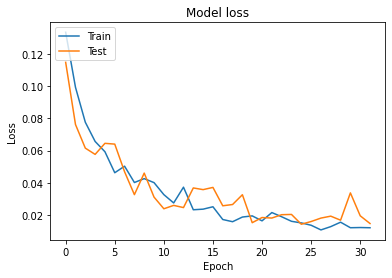

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# plot the training loss and accuracy
# N = EPOCHS
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig(plot_path)